# Face Mask Detection Using YOLOv8

**Course:** ITAI 1378 - Computer Vision & AI

**Student:** Jaret Sanchez

This notebook trains and evaluates my model that will detect if people are wearing a mask, not wearing a mask or wearing it incorrectly.

## 1. Environment Setup

In [1]:
# I will check my GPU first
# Tesla T4 is a good option for my tier one project
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU not available"

(True, 'Tesla T4')

In [2]:
 # I will install YOLOv8
!pip install ultralytics

import os
import torch
import ultralytics
from ultralytics import YOLO

# I will try to disable Weights & Biases. I have trouble disabling it so if it doesn't work I will just type 3 and keep going with the notebook
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["ULTRALYTICS_WANDB"] = "False"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Dataset Setup

This project uses the **Face Mask Detection** dataset from Kaggle (Andrew Mvd):

- Classes: `with_mask`, `without_mask`, `mask_weared_incorrect`
- Dataset link: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

In this notebook, the XML annotations are converted into YOLO format and split into training and validation sets.

In [3]:
# I downloaded the dataset ZIP from Kaggle and unzip it
!mkdir -p /content/data
!unzip -q "/content/archive.zip" -d /content/data
!ls /content/data

annotations  images


In [4]:
# The Kaggle dataset uses Pascal VOC XML, I need to convert it to YOLO format
import os
import xml.etree.ElementTree as ET
from pathlib import Path


images_dir = Path("/content/data/images")
xml_dir = Path("/content/data/annotations")
output_images_dir = Path("/content/data/images")
output_labels_dir = Path("/content/data/labels")

output_images_dir.mkdir(parents=True, exist_ok=True)
output_labels_dir.mkdir(parents=True, exist_ok=True)

# Map VOC class names to YOLO class IDs
class_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}

def voc_to_yolo_bbox(size, box):
    # size: (width, height)
    # box: (xmin, ymin, xmax, ymax)
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

for xml_file in xml_dir.glob("*.xml"):
    tree = ET.parse(str(xml_file))
    root = tree.getroot()

    filename = root.find("filename").text
    img_path = images_dir / filename

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    # copy image to output_images_dir
    if img_path.exists():
        os.system(f'cp "{img_path}" "{output_images_dir}"')

    # create corresponding label file
    label_path = output_labels_dir / (Path(filename).stem + ".txt")
    with open(label_path, "w") as f:
        for obj in root.findall("object"):
            cls_name = obj.find("name").text
            if cls_name not in class_map:
                continue
            cls_id = class_map[cls_name]
            xmlbox = obj.find("bndbox")
            xmin = float(xmlbox.find("xmin").text)
            ymin = float(xmlbox.find("ymin").text)
            xmax = float(xmlbox.find("xmax").text)
            ymax = float(xmlbox.find("ymax").text)
            x, y, bw, bh = voc_to_yolo_bbox((w, h), (xmin, ymin, xmax, ymax))
            f.write(f"{cls_id} {x} {y} {bw} {bh}\n")

print("Conversion complete.")

Conversion complete.


In [5]:
# After doing the conversion, I will create the train and val splits
# The project is Tier 1 so doing a single split of 80% train, and 20% val will be okay for the model
import random
from pathlib import Path
import shutil

random.seed(42)

base_images = Path("/content/data/images")
base_labels = Path("/content/data/labels")

train_images = Path("/content/dataset/images/train")
val_images = Path("/content/dataset/images/val")
train_labels = Path("/content/dataset/labels/train")
val_labels = Path("/content/dataset/labels/val")

for p in [train_images, val_images, train_labels, val_labels]:
    p.mkdir(parents=True, exist_ok=True)

all_images = list(base_images.glob("*.jpg")) + list(base_images.glob("*.png"))
random.shuffle(all_images)

split_idx = int(0.8 * len(all_images))
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

def move_pair(img_list, dest_img_dir, dest_lbl_dir):
    for img_path in img_list:
        lbl_path = base_labels / (img_path.stem + ".txt")
        if not lbl_path.exists():
            continue
        shutil.copy2(img_path, dest_img_dir / img_path.name)
        shutil.copy2(lbl_path, dest_lbl_dir / lbl_path.name)

move_pair(train_files, train_images, train_labels)
move_pair(val_files, val_images, val_labels)

len(train_files), len(val_files)

(682, 171)

In [6]:
# I splited the data and the next step is to create the YOLO data configuration YAML
data_yaml = """
path: /content/dataset

train: images/train
val: images/val

names:
  0: with_mask
  1: without_mask
  2: mask_weared_incorrect
"""

with open("/content/dataset/face_mask.yaml", "w") as f:
    f.write(data_yaml)

print(open("/content/dataset/face_mask.yaml").read())


path: /content/dataset

train: images/train
val: images/val

names:
  0: with_mask
  1: without_mask
  2: mask_weared_incorrect



## 3. Model Training

In this section, a pretrained YOLOv8 model is fine-tuned on the face mask dataset.

Key settings:
- Base model: `yolov8n.pt`
- Image size: 640 × 640
- Epochs: 30
- Batch size: 16


In [7]:
model = YOLO("yolov8n.pt")

# Train the model
results = model.train(
    data="/content/dataset/face_mask.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    name="face_mask_yolov8",
    device=0 if torch.cuda.is_available() else "cpu"
)

Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/face_mask.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_mask_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

In [8]:
best_model = YOLO("/content/runs/detect/face_mask_yolov8/weights/best.pt")

metrics = best_model.val(
    data="/content/dataset/face_mask.yaml",
    imgsz=640
)

metrics.results_dict

Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3754.0±1733.0 MB/s, size: 392.4 KB)
val: Scanning /content/dataset/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 309.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.9it/s 5.9s
                   all        171        697      0.935      0.707      0.823      0.576
             with_mask        148        533      0.982      0.886      0.968      0.696
          without_mask         59        151      0.921      0.697       0.88      0.558
 mask_weared_incorrect         11         13      0.901      0.538      0.621      0.475
Speed: 2.8ms preprocess, 8.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/runs/detect/val


{'metrics/precision(B)': 0.9348704954015874,
 'metrics/recall(B)': 0.7069231287161898,
 'metrics/mAP50(B)': 0.8233033950054556,
 'metrics/mAP50-95(B)': 0.5761175845347581,
 'fitness': 0.5761175845347581}

## 4. Evaluation (Metrics)

- Precision: 0.934
- Recall: 0.706
- mAP50: 0.823
- mAP50-95: 0.576

The model performs best on ***with_mask*** and struggles more with ***mask_weared_incorrect***,
which is likely due to (small faces, occlusions, imbalanced samples, etc.).

## 5. Visualizing Predictions


image 1/171 /content/dataset/images/val/maksssksksss103.png: 480x640 4 with_masks, 39.7ms
image 2/171 /content/dataset/images/val/maksssksksss105.png: 448x640 10 with_masks, 1 without_mask, 39.6ms
image 3/171 /content/dataset/images/val/maksssksksss107.png: 640x512 1 with_mask, 41.2ms
image 4/171 /content/dataset/images/val/maksssksksss110.png: 448x640 13 with_masks, 20 without_masks, 1 mask_weared_incorrect, 6.7ms
image 5/171 /content/dataset/images/val/maksssksksss116.png: 384x640 5 with_masks, 39.4ms
image 6/171 /content/dataset/images/val/maksssksksss117.png: 640x512 1 with_mask, 6.6ms
image 7/171 /content/dataset/images/val/maksssksksss119.png: 480x640 5 with_masks, 2 without_masks, 6.5ms
image 8/171 /content/dataset/images/val/maksssksksss122.png: 448x640 1 with_mask, 6.4ms
image 9/171 /content/dataset/images/val/maksssksksss123.png: 512x640 2 with_masks, 50.4ms
image 10/171 /content/dataset/images/val/maksssksksss124.png: 448x640 3 with_masks, 3 without_masks, 6.5ms
image 11/17

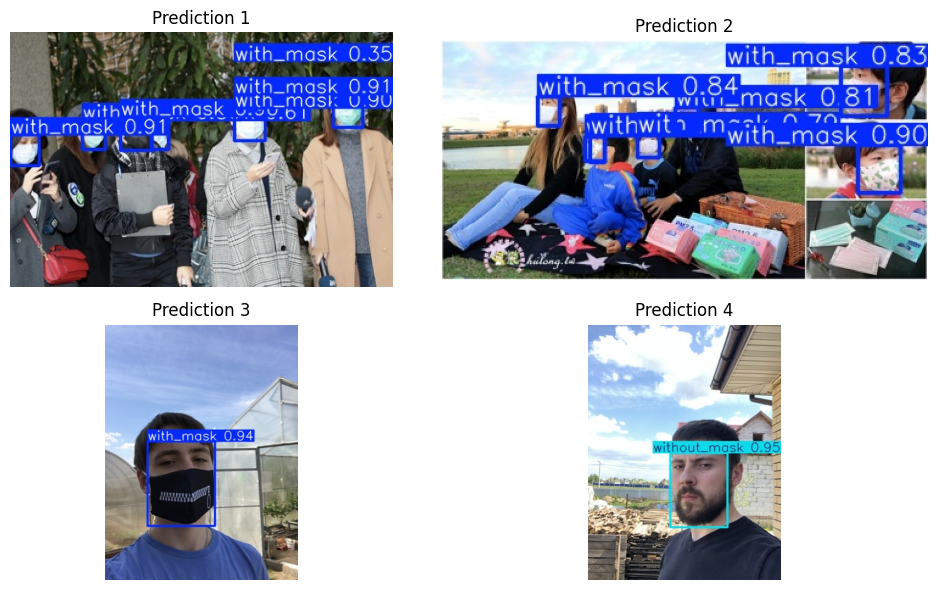

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

val_dir = "/content/dataset/images/val"
pred_dir = "/content/predictions"


pred_results = model.predict(
    source=val_dir,
    save=True,
    save_txt=False,
    project=pred_dir,
    name="cv_demo",
    exist_ok=True
)

predicted_dir = os.path.join(pred_dir, "cv_demo")
print("Predicted images directory:", predicted_dir)

predicted_image_files = glob.glob(os.path.join(predicted_dir, "*"))
predicted_image_files = [
    f for f in predicted_image_files
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

print("Number of predicted images found:", len(predicted_image_files))


num_images = min(4, len(predicted_image_files))
cols = 2
rows = (num_images + 1) // cols

plt.figure(figsize=(10, 6))
for i, img_path in enumerate(predicted_image_files[:num_images]):
    img = Image.open(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction {i+1}")
plt.tight_layout()
plt.show()

## 6. Reflection

Working on this project helps me understand better how an object detection system functions. I learned how to prepare a dataset and convert annotations into the right format, how to train and evaluate a YOLOv8 model in Google Colab, how to interpret metrics, and how to visualize success and failure predictions. It was a challenging project, but it was a rewarding experience. The professor's instructions were life savers, all of her files have very detailed steps to complete this final assignment. In the future, I would like to choose a tier 2 or even a tier 3 project, but with my current knowledge, a tier 1 was a perfect and challenging enough option.

## 7. Interactive Demo

In this section, you can upload one or more images and run the trained YOLOv8 model to see face mask detections. This simulates how the model could be used in a real-world application.

Saving example_4.jpg to example_4.jpg
Saving example_3.jpg to example_3.jpg
Saving example_2.jpg to example_2.jpg
Saving example_1.jpg to example_1.jpg
4 file(s) uploaded.

Running detection on: example_4.jpg

0: 448x640 5 with_masks, 12.9ms
Speed: 3.9ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


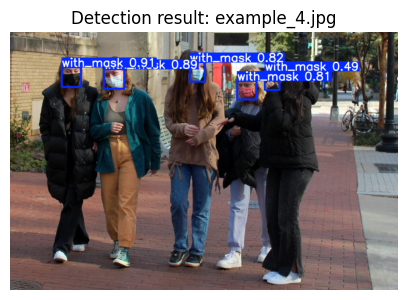


Running detection on: example_3.jpg

0: 480x640 2 with_masks, 2 without_masks, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


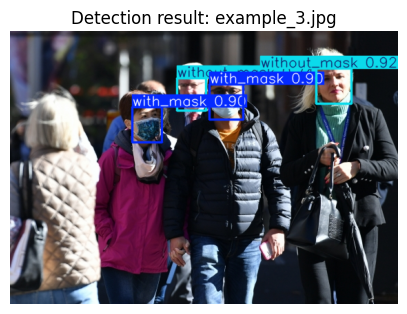


Running detection on: example_2.jpg

0: 448x640 2 with_masks, 5 without_masks, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


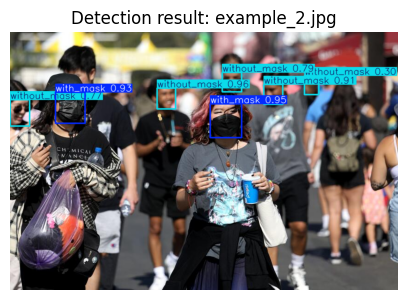


Running detection on: example_1.jpg

0: 448x640 12 with_masks, 3 without_masks, 1 mask_weared_incorrect, 8.6ms
Speed: 4.1ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


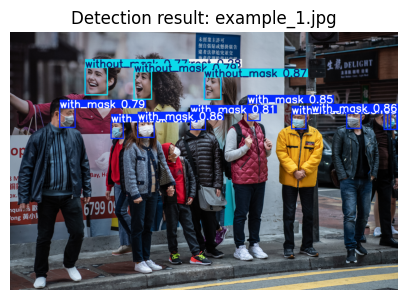

In [10]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import io

def run_demo_multi():
    uploaded = files.upload()
    if not uploaded:
        print("No files uploaded.")
        return

    print(f"{len(uploaded)} file(s) uploaded.")

    for filename, filedata in uploaded.items():
        print(f"\nRunning detection on: {filename}")

        img = Image.open(io.BytesIO(filedata))

        results = best_model.predict(
            source=img,
            imgsz=640
        )

        plotted = results[0].plot()
        plotted = plotted[..., ::-1]

        plt.figure(figsize=(5, 5))
        plt.imshow(plotted)
        plt.axis("off")
        plt.title(f"Detection result: {filename}")
        plt.show()

run_demo_multi()
